In [1]:
# 기본 환경 로드
%run ./env.ipynb

# Fit Data Model

ETL를 통해 생성된 데이터셋을 이용하여 훈련을 통해 데이터 모델을 생성합니다.

In [2]:
from utils import *

sdate = get_env_sdate(default = "2018070108")
path_base = get_env_path_base(default = "/root/mnt/dfs/notebooks-skp/mnist")
path_data = get_env_path_date(default = "/root/mnt/dfs/data/mnist")

print("sdate: {}".format(sdate))
print("path_base: {}".format(path_base))
print("path_data: {}".format(path_data))

sdate: 2018070108
path_base: /root/mnt/dfs/notebooks-skp/mnist
path_data: /root/mnt/dfs/data/mnist


In [3]:
# 데이터 로드
import os
from sklearn.externals import joblib 

path_etl = os.path.join(path_data, "etl")
path_etl_sdate = os.path.join(path_etl, sdate)

path_train_xs = os.path.join(path_etl_sdate, "cnn-train_xs.pkl")
path_train_ys = os.path.join(path_etl_sdate, "cnn-train_ys.pkl")
np_train_xs = joblib.load(path_train_xs)
np_train_ys = joblib.load(path_train_ys)
print(np_train_xs.shape, np_train_ys.shape)

path_test_xs = os.path.join(path_etl_sdate, "cnn-test_xs.pkl")
path_test_ys = os.path.join(path_etl_sdate, "cnn-test_ys.pkl")
np_test_xs = joblib.load(path_test_xs)
np_test_ys = joblib.load(path_test_ys)
print(np_test_xs.shape, np_test_ys.shape)

(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)


In [4]:
dim_x = np_train_xs.shape[1]
n_class = np_train_ys.shape[1]

In [5]:
# Keras: set GPU options for Tensorflow Backend
import tensorflow as tf
from keras import backend as k
 
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
sess = tf.Session(config=config)
k.tensorflow_backend.set_session(sess)

Using TensorFlow backend.


In [6]:
# 모델 로드
from fdm_model import create_cnn

img_rows, img_cols = np_train_xs.shape[1], np_train_xs.shape[2]
input_shape = (img_rows, img_cols, 1)

model = create_cnn(input_shape=input_shape, n_class=n_class)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total para

In [7]:
from keras import callbacks

# 훈련을 통해 제일 좋은 성능을 보인 모델만을 저장합니다.
with sess.graph.as_default():
    path_fdm = os.path.join(path_data, "fdm")
    path_fdm_sdate = os.path.join(path_fdm, sdate)
    os.makedirs(path_fdm_sdate, exist_ok=True)

    # path_model = os.path.join(path_fdm_sdate, "cnn-{epoch:02d}-{val_loss:.2f}.hdf5")
    path_model = os.path.join(path_fdm_sdate, "cnn-best.hdf5")

    epochs = 10
    batch_size = 100
    checkpoint = callbacks.ModelCheckpoint(path_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    earlystop = callbacks.EarlyStopping(monitor='val_acc', patience=int(epochs * 0.3), mode='auto')
    callbacks_list = [checkpoint, earlystop]

    history = model.fit(np_train_xs, np_train_ys, batch_size=batch_size, epochs=epochs, verbose=2, callbacks=callbacks_list, validation_split=0.3, shuffle=True)

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
 - 4s - loss: 0.2977 - acc: 0.9075 - val_loss: 0.0728 - val_acc: 0.9797

Epoch 00001: val_acc improved from -inf to 0.97972, saving model to /root/mnt/dfs/data/mnist/fdm/2018070108/cnn-best.hdf5
Epoch 2/10
 - 3s - loss: 0.0968 - acc: 0.9717 - val_loss: 0.0603 - val_acc: 0.9819

Epoch 00002: val_acc improved from 0.97972 to 0.98194, saving model to /root/mnt/dfs/data/mnist/fdm/2018070108/cnn-best.hdf5
Epoch 3/10
 - 3s - loss: 0.0725 - acc: 0.9774 - val_loss: 0.0484 - val_acc: 0.9858

Epoch 00003: val_acc improved from 0.98194 to 0.98583, saving model to /root/mnt/dfs/data/mnist/fdm/2018070108/cnn-best.hdf5
Epoch 4/10
 - 3s - loss: 0.0576 - acc: 0.9821 - val_loss: 0.0521 - val_acc: 0.9848

Epoch 00004: val_acc did not improve from 0.98583
Epoch 5/10
 - 3s - loss: 0.0478 - acc: 0.9851 - val_loss: 0.0444 - val_acc: 0.9869

Epoch 00005: val_acc improved from 0.98583 to 0.98689, saving model to /root/mnt/dfs/data/mnist/fdm/20180701

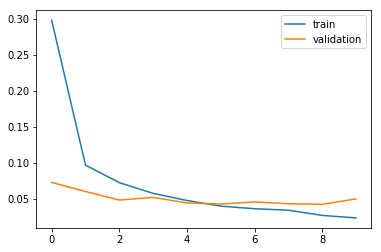

In [8]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [9]:
# 가중치 로드
from keras import callbacks

path_fdm = os.path.join(path_data, "fdm")
path_fdm_sdate = os.path.join(path_fdm, sdate)

# path_model = os.path.join(path_fdm_sdate, "cnn-{epoch:02d}-{val_loss:.2f}.hdf5")
path_model = os.path.join(path_fdm_sdate, "cnn-best.hdf5")

model.load_weights(path_model)

In [10]:
with sess.graph.as_default():
    np_pred_ys = model.predict(np_test_xs)
    print(np_pred_ys.shape)

(10000, 10)


In [11]:
from sklearn import metrics 
from sklearn.metrics import classification_report

np_pred_ys = model.predict_classes(np_test_xs)
np_real_ys = np.argmax(np_test_ys, axis=1)

print("\n")
print(classification_report(np_real_ys, np_pred_ys))



             precision    recall  f1-score   support

          0       0.99      0.99      0.99       980
          1       0.99      0.99      0.99      1135
          2       0.98      1.00      0.99      1032
          3       0.98      1.00      0.99      1010
          4       1.00      0.99      0.99       982
          5       0.99      0.98      0.99       892
          6       0.99      0.98      0.99       958
          7       0.99      0.99      0.99      1028
          8       0.99      0.99      0.99       974
          9       0.99      0.98      0.99      1009

avg / total       0.99      0.99      0.99     10000

